In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from types import SimpleNamespace
import numpy as np
import matplotlib.colors as mcolors
import math

try:
    from scipy.integrate import trapezoid, cumulative_trapezoid
except ImportError:
    from scipy.integrate import trapz as trapezoid
    from scipy.integrate import cumtrapz as cumulative_trapezoid

from scipy.optimize import fsolve
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from matplotlib.ticker import LogLocator, LogFormatter, LogFormatterMathtext, FixedLocator, FixedFormatter, MultipleLocator, NullFormatter
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
sys.stderr = open(os.devnull, 'w')

paper_mode=False

if paper_mode:
    fontsize_global=30 # 30
    rc('text', usetex=True)  # switch to True for latex font (might be slow)
    rcParams.update({
        "xtick.major.size": 8, "xtick.minor.size": 4, "ytick.major.size": 8, "ytick.minor.size": 4,
        'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True,
        'font.size': fontsize_global,    'axes.labelsize': fontsize_global, 'xtick.labelsize': fontsize_global, 'ytick.labelsize': fontsize_global,
        'axes.grid': False, 'grid.alpha': 0.3,'axes.linewidth': 2.3, 'xtick.major.width': 2.3,  # Major tick width on x-axis
        'xtick.minor.width': 1.0,  # Minor tick width on x-axis
        'ytick.major.width': 2.3,  # Major tick width on y-axis
        'ytick.minor.width': 1.0})

    plt.rcParams.update({
        'text.usetex': True,               # Use LaTeX for typesetting
        'font.family': 'serif',
        'font.serif': ['Helvetica'],  # Use the same serif font as MATLAB
        'axes.unicode_minus': False        # To ensure minus sign renders correctly
    })
else:
    fontsize_global=20
    rc('text', usetex=True)  # switch to True for latex font (might be slow)
    rcParams.update({
        "xtick.major.size": 6, "xtick.minor.size": 3, "ytick.major.size": 6, "ytick.minor.size": 3,
        'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True,
        'font.size': fontsize_global,    'axes.labelsize': fontsize_global, 'xtick.labelsize': fontsize_global, 'ytick.labelsize': fontsize_global,
        'axes.grid': False, 'grid.alpha': 0.3,'axes.linewidth': 2.0, 'xtick.major.width': 2.0,  # Major tick width on x-axis
        'xtick.minor.width': 1.0,  # Minor tick width on x-axis
        'ytick.major.width': 2.0,  # Major tick width on y-axis
        'ytick.minor.width': 1.0})
    rcParams['mathtext.fontset'] = 'stix'


from IPython.core.display import HTML
HTML('''
    <style>
        .container { 
            width: 95% !important;
        }
        .output_wrapper, .output {
            height: auto !important;
            max-height: none !important;
        }
    </style>
''')

<br>

# Load files
<br>

<hr style="border:0.5px solid black">

In [18]:
def setup_Tw(fol, params):
    Tw = SimpleNamespace()

    # Set dataset-specific parameters
    timestamp = params['timestamp']
    Tw.Minf = params['Minf']
    Tw.Prinf = params['Prinf']
    Tw.Re_bulk = params['Re_bulk']

    Tw.x = np.fromfile(f"{fol}/x.bin")
    
    Tw.imax = len(Tw.x)

    print(f'# Dataset: {fol}')
    print('#1: ' + str(Tw.imax))
    print(str(Tw.x[-1]))
    print('#################################################')

    # Reynolds average
    Tw.t_avg = np.fromfile(f"{fol}/t_avg.{timestamp:07d}.bin")
    Tw.w_avg = np.fromfile(f"{fol}/w_avg.{timestamp:07d}.bin")
    Tw.u_avg = np.fromfile(f"{fol}/u_avg.{timestamp:07d}.bin")
    Tw.v_avg = np.fromfile(f"{fol}/v_avg.{timestamp:07d}.bin")
    Tw.r_avg = np.fromfile(f"{fol}/r_avg.{timestamp:07d}.bin")
    Tw.p_avg = np.fromfile(f"{fol}/p_avg.{timestamp:07d}.bin")
    Tw.mu_avg = np.fromfile(f"{fol}/mu_avg.{timestamp:07d}.bin")
    Tw.Pr_avg = np.fromfile(f"{fol}/Pr_avg.{timestamp:07d}.bin")
    Tw.Cp_avg = np.fromfile(f"{fol}/Cp_avg.{timestamp:07d}.bin")
    Tw.ka_avg = np.fromfile(f"{fol}/ka_avg.{timestamp:07d}.bin")
    Tw.ien_avg = np.fromfile(f"{fol}/ien_avg.{timestamp:07d}.bin")
    Tw.ent_avg = np.fromfile(f"{fol}/ent_avg.{timestamp:07d}.bin")
    Tw.sos_avg = np.fromfile(f"{fol}/sos_avg.{timestamp:07d}.bin")
    
    Tw.tauxz_avg = np.fromfile(f"{fol}/tauxz_avg.{timestamp:07d}.bin")
    
    Tw.w_max = np.max(Tw.w_avg)
    Tw.i_max = int(np.argmax(Tw.w_avg))
    Tw.w_profile = Tw.w_avg[:]/Tw.w_max
 
    # Favre average
    Tw.ru_avg = np.fromfile(f"{fol}/ru_avg.{timestamp:07d}.bin")
    Tw.rv_avg = np.fromfile(f"{fol}/rv_avg.{timestamp:07d}.bin")
    Tw.rw_avg = np.fromfile(f"{fol}/rw_avg.{timestamp:07d}.bin")
    Tw.wF_avg = Tw.rw_avg/Tw.r_avg
    Tw.rt_avg = np.fromfile(f"{fol}/rt_avg.{timestamp:07d}.bin")
    Tw.tF_avg = Tw.rt_avg/Tw.r_avg
    Tw.rent_avg = np.fromfile(f"{fol}/rent_avg.{timestamp:07d}.bin")
        
    # Second-order Reynolds statistics
    Tw.rhorho_avg = np.fromfile(f"{fol}/rhorho_avg.{timestamp:07d}.bin")
    Tw.mumu_avg = np.fromfile(f"{fol}/mumu_avg.{timestamp:07d}.bin")
    Tw.temtem_avg = np.fromfile(f"{fol}/temtem_avg.{timestamp:07d}.bin")
    Tw.kaka_avg = np.fromfile(f"{fol}/kaka_avg.{timestamp:07d}.bin")
    Tw.cpcp_avg = np.fromfile(f"{fol}/cpcp_avg.{timestamp:07d}.bin")
    Tw.PrPr_avg = np.fromfile(f"{fol}/PrPr_avg.{timestamp:07d}.bin")
    
    # Second-order Favre statistics
    Tw.ruu_avg = np.fromfile(f"{fol}/ruu_avg.{timestamp:07d}.bin")
    Tw.ruw_avg = np.fromfile(f"{fol}/ruw_avg.{timestamp:07d}.bin")
    Tw.rvv_avg = np.fromfile(f"{fol}/rvv_avg.{timestamp:07d}.bin")
    Tw.rww_avg = np.fromfile(f"{fol}/rww_avg.{timestamp:07d}.bin")
    Tw.rutem_avg = np.fromfile(f"{fol}/rutem_avg.{timestamp:07d}.bin")
    
    # Viscosity
    Tw.dwdx_avg = np.fromfile(f"{fol}/dwdx_avg.{timestamp:07d}.bin")
    Tw.mudwdx_avg = np.fromfile(f"{fol}/mudwdx_avg.{timestamp:07d}.bin")
    
    # Skin friction coefficient
    #Tw.tauw = (Tw.mu_avg[0] + Tw.mu_avg[1]) / 2 * Tw.w_avg[1] / Tw.x[1]
    Tw.tauw = Tw.tauxz_avg[0]
    Tw.utau = np.sqrt(Tw.tauw / Tw.r_avg[0])
    Tw.cf_calc = 2 * Tw.tauw
    
    # Turbulent constants
    Tw.Karman_const = 0.41
    Tw.intercept = 5.2
    Tw.Aplus = 17.0
    
    # Turbulent parameters
    Tw.yplus = np.zeros((Tw.imax))
    Tw.fact_star = np.zeros((Tw.imax))
    Tw.ystar = np.zeros((Tw.imax))
    Tw.utaustar = np.zeros((Tw.imax))
    Tw.Retaustar = np.zeros((Tw.imax))
    
    Tw.Retauw = Tw.utau * Tw.r_avg[0] / Tw.mu_avg[0]
    Tw.yplus = Tw.x * Tw.Retauw
    Tw.fact_star[:] = np.sqrt(Tw.r_avg[:] / Tw.r_avg[0]) / (Tw.mu_avg[:] / Tw.mu_avg[0])
    Tw.ystar[:] = Tw.yplus[:] * Tw.fact_star[:]
    Tw.utaustar[:] = np.sqrt(Tw.tauw / Tw.r_avg[:])
    Tw.Retaustar[:] = Tw.Retauw * Tw.fact_star[:]
    
    # Streamwise Reynolds normal stress
    Tw.rsxx_avg = Tw.rww_avg/Tw.r_avg - (Tw.rw_avg*Tw.rw_avg)/Tw.r_avg**2
    # Wall-normal Reynolds normal stress
    Tw.rsyy_avg = Tw.ruu_avg/Tw.r_avg - (Tw.ru_avg*Tw.ru_avg)/Tw.r_avg**2
    # Spanwise Reynolds normal stress
    Tw.rszz_avg = Tw.rvv_avg/Tw.r_avg - (Tw.rv_avg*Tw.rv_avg)/Tw.r_avg**2
    # Reynolds-shear stress
    Tw.rsxy_avg = Tw.ruw_avg/Tw.r_avg - (Tw.ru_avg*Tw.rw_avg)/Tw.r_avg**2
    # Convective flux
    Tw.cxy_avg = (Tw.ru_avg*Tw.rw_avg)/Tw.r_avg**2


    return Tw

# Define dataset-specific parameters
datasets = [ ('stats', {
        'timestamp': 1200000, 'Minf': 0.2, 'Prinf': 0.75, 'Re_bulk': 2800
            }),
            ]

Tw_datasets = [setup_Tw(fol, params) for fol, params in datasets]
    

# Dataset: stats
#1: 129
1.998846619051679
#################################################


# Primary variables

Re_tau,wall = 181.491
y_plus(1) = 0.209328
Re_tau,star = 181.491


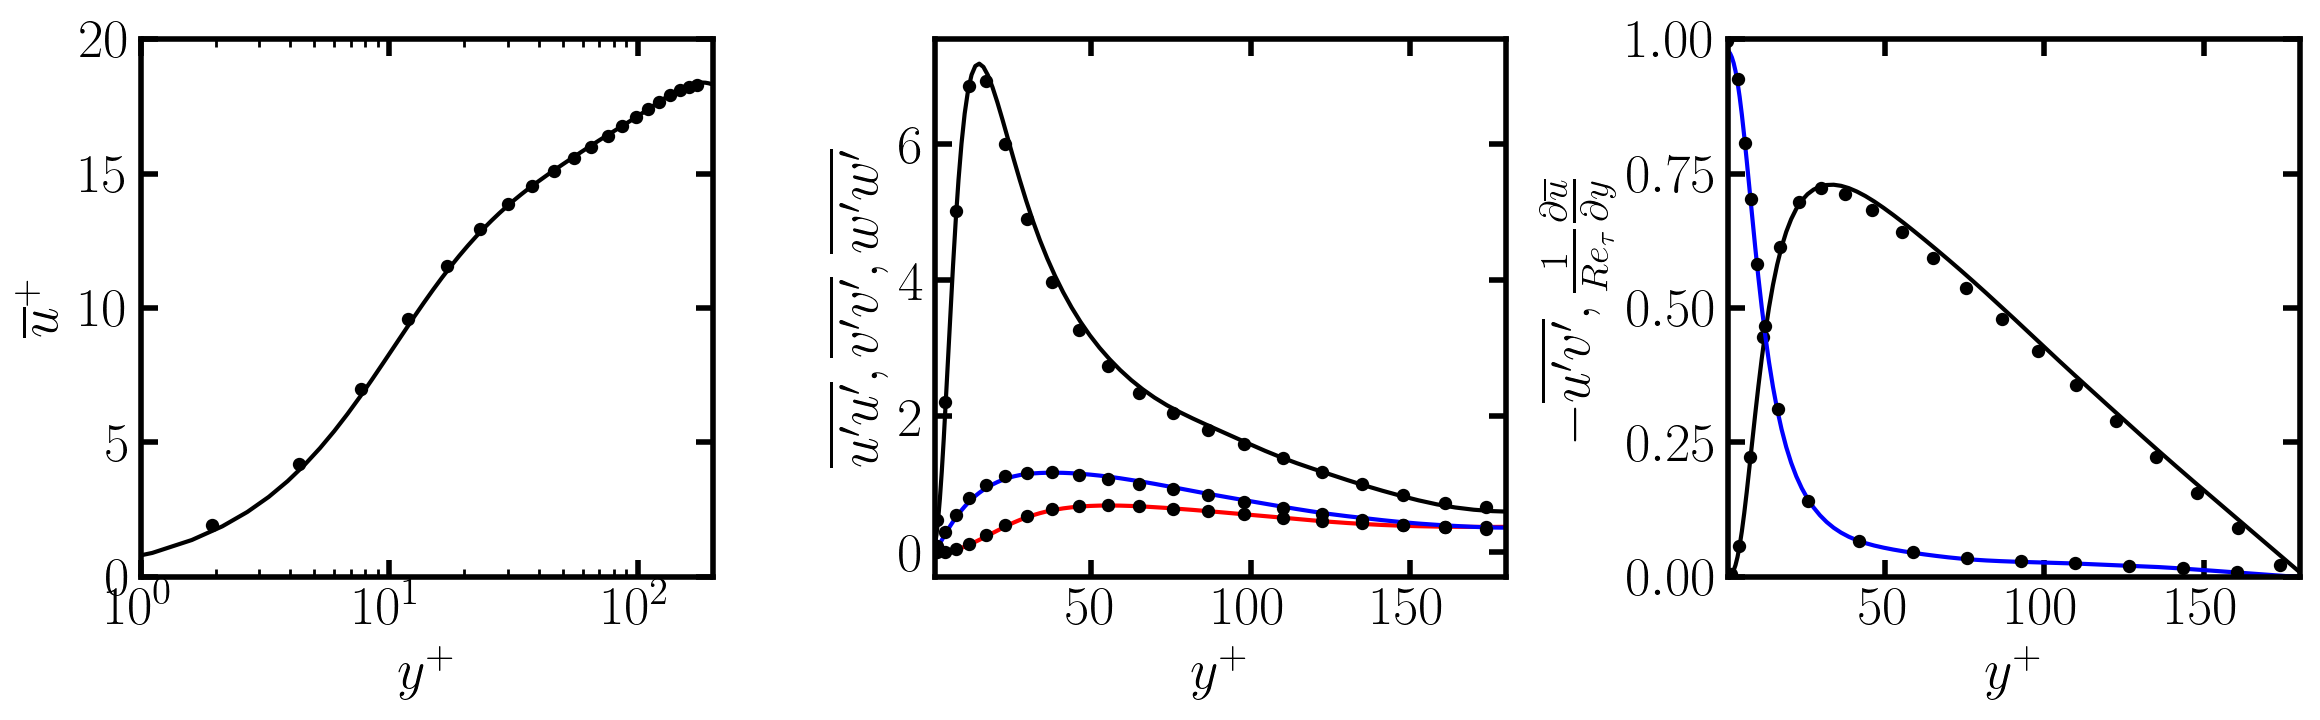

In [22]:
for i, (Tw, params) in enumerate(zip(Tw_datasets, datasets), 1):

    # x-axis limit for semilogx plots
    ylim = 2e2

    # Print some key values for debugging
    print(f"Re_tau,wall = {Tw.Retauw:.6g}")
    print(f"y_plus(1) = {Tw.yplus[0]:.6g}")
    print(f"Re_tau,star = {Tw.Retaustar[0]:.6g}")
    
    Tw.u_plus=Tw.w_avg/Tw.utau
    Tw.w_plus=Tw.v_avg/Tw.utau
    Tw.duplusdy = 1/Tw.utau*(Tw.w_avg[1:] - Tw.w_avg[:-1]) / (Tw.x[1:] - Tw.x[:-1])
    Tw.visc_y= 1/Tw.Retaustar[:-1]*Tw.duplusdy
    Tw.visc_y=np.append(Tw.visc_y,1e-10)
    
    # Import reference solution at Re_tau=180 (Kim, Moin & Moser, 1987, J. Fluid Mech. vol 177, 133-166)
    yplus_ref = np.loadtxt("literature/Re180.yplus.txt")
    uplus_ref = np.loadtxt("literature/Re180.Umean.txt")
    wplus_ref = np.loadtxt("literature/Re180.Wmean.txt")
    Ruu_ref = np.loadtxt("literature/Re180.R_uu.txt")
    Rvv_ref = np.loadtxt("literature/Re180.R_vv.txt")
    Rww_ref = np.loadtxt("literature/Re180.R_ww.txt")
    Ruv_ref = np.loadtxt("literature/Re180.R_uv.txt")
    Sy_ref = np.loadtxt("literature/Re180.S_y.txt")
    ySy_ref = np.loadtxt("literature/Re180.y_Sy.txt")
    
    # Setup for the subplots
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Highlight the profile at the index_profile
    ax[0].semilogx(Tw.yplus, Tw.u_plus, color='black', lw=1.5)
    ax[0].semilogx(yplus_ref[::3], uplus_ref[::3],
               'o', ms=4, mfc='black', mec='black', mew=0.8, lw=0)
    ax[0].set_xlim(1e0, ylim)
    ax[0].set_ylim(0,20)
    ax[0].set_xlabel(r"$y^+$", fontsize=fontsize_global)
    ax[0].set_ylabel(r"$\overline{u}^+$", fontsize=fontsize_global)
    
    ax[1].plot(Tw.yplus, Tw.rsxx_avg/Tw.utau**2, color='black', lw=1.5)
    ax[1].plot(yplus_ref[::3], Ruu_ref[::3],
               'o', ms=4, mfc='black', mec='black', mew=0.8, lw=0)
    ax[1].plot(Tw.yplus, Tw.rsyy_avg/Tw.utau**2, color='red', lw=1.5)
    ax[1].plot(yplus_ref[::3], Rvv_ref[::3],
               'o', ms=4, mfc='black', mec='black', mew=0.8, lw=0)
    ax[1].plot(Tw.yplus, Tw.rszz_avg/Tw.utau**2, color='blue', lw=1.5)
    ax[1].plot(yplus_ref[::3], Rww_ref[::3],
               'o', ms=4, mfc='black', mec='black', mew=0.8, lw=0)
    ax[1].set_xlim(1e0, 180)
    ax[1].set_xlabel(r"$y^+$", fontsize=fontsize_global)
    ax[1].set_ylabel(r"$\overline{u^\prime u^\prime}, \overline{v^\prime v^\prime}, \overline{w^\prime w^\prime}$", fontsize=fontsize_global)
    
    ax[2].plot(Tw.yplus, -Tw.rsxy_avg/Tw.utau**2, color='black', lw=1.5)
    ax[2].plot(yplus_ref[::3], -Ruv_ref[::3],
               'o', ms=4, mfc='black', mec='black', mew=0.8, lw=0)
    ax[2].plot(Tw.yplus, Tw.visc_y, color='blue', lw=1.5)
    ax[2].plot(ySy_ref[::3], Sy_ref[::3],
               'o', ms=4, mfc='black', mec='black', mew=0.8, lw=0)
    ax[2].set_xlim(1e0, 180)
    ax[2].set_ylim(0, 1)
    ax[2].set_xlabel(r"$y^+$", fontsize=fontsize_global)
    ax[2].set_ylabel(r"$-\overline{u^\prime v^\prime}, \frac{1}{Re_\tau} \frac{\partial \overline{u}}{\partial y}$", fontsize=fontsize_global)

    # Apply tight layout to avoid overlap
    fig.tight_layout()
    plt.show()